In [ ]:
%%capture
!pip install transformers
!pip install datasets

## Libraries Import

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from imblearn import under_sampling
from datasets import load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
%matplotlib inline

## Load "tweets_hate_speech_detection" Dataset from Hugging Face 

In [ ]:
dataset = load_dataset("tweets_hate_speech_detection")

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (/root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset['train']

Dataset({
    features: ['label', 'tweet'],
    num_rows: 31962
})

In [ ]:
df_1 = pd.DataFrame(columns = ['class','tweet'])
df_1['tweet'] = dataset['train']['tweet']
df_1['class'] = dataset['train']['label']

## Original class imbalance

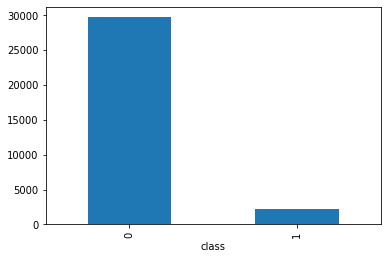

In [ ]:
df_1.groupby(['class']).size().plot.bar()

## Perform Data re-sampling

In [ ]:
undersampler = under_sampling.RandomUnderSampler(sampling_strategy = 'all', random_state = 42)
tweets, classes = undersampler.fit_resample(np.array(df_1['tweet']).reshape(-1,1), df_1['class'])
tweets, classes = undersampler.fit_resample(tweets, classes)

In [ ]:
df = pd.DataFrame(columns = ['tweet','class'])
df['tweet'] = pd.DataFrame(tweets)
df['class'] = pd.DataFrame(classes)

## Class distribuition after re-balancing

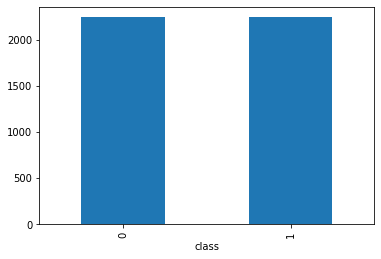

In [ ]:
df.groupby(['class']).size().plot.bar()

## Class for importing and tokenizing the dataset

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = {0:0,
          1:1}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['class']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 50, truncation=True,
                                return_tensors="pt") for text in df['tweet']]
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

## Class for defining the Bert model and classifier architecture
In this case, the architecture is conformed by two RELU layers, one Linear layer and lately, one Softmax function.

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        #dropout_output = self.dropout(pooled_output)
        #linear_output = self.linear(dropout_output)
        relu_1=self.relu(pooled_output)
        relu_2=self.relu(relu_1)
        final_layer1 = self.linear(relu_2)
        final_layer = self.softmax(final_layer1)


        return final_layer

## Define the trainning function

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs,batch):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    #criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')

## Define the out-of-sample evaluation function (Accuracy and ROC curve)

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    return total_acc_test / len(test_data)

from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(model, test_data):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)
    preds = []
    y_true = []

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
    
        for test_input, test_label in test_dataloader:
              
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              y_true.append(test_label.cpu().numpy())
              preds.append(model(input_id, mask).cpu().detach().numpy()[0][1])
              #print(y_true,preds)
      
    preds = np.array(preds).astype(float)
    y_true = np.array(y_true).astype(float)
    #print(preds,y_true)
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return roc_auc

## Perform data splitting into train,test and validation.

In [ ]:
np.random.seed(112)
#df = df.sample(n=4000)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

3587 448 449


## Grid Search 
Parameter optimization was performed for the specified lists of hyper-parameters. Once the model was selected, the training was commented out since it took too long to run.

In [ ]:
#EPOCHS = [1,2]
#BATCHES = [16,32]
#LR_LIST = [1e-12,1e-9]
#results = pd.DataFrame(columns = ['Epochs','Batch_size','LR','Test_accuracy'])
#
#for epoch in EPOCHS:
#  for batch in BATCHES:
#    for lr in LR_LIST:
#      model = BertClassifier()
#      train(model, df_train, df_val, lr, epoch,batch)
#      acc = evaluate_roc(model,df_test)
#      results = results.append({'Epochs':epoch,'Batch_size':batch,'Test_accuracy': acc,'LR':lr}, ignore_index=True)

## Test accuracy results for non-balanced data over hyper-parameter search

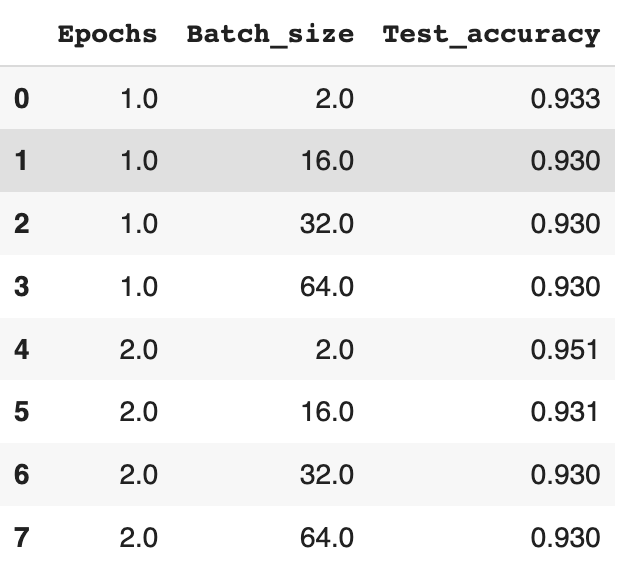

## Instanciate and train the best performing model

In [ ]:
model = BertClassifier()
LR = 1e-6
train(model, df_train, df_val, LR, epochs=1,batch=64)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 57/57 [00:53<00:00,  1.06it/s]


Epochs: 1 | Train Loss:  0.011 | Train Accuracy:  0.640 | Val Loss:  0.011 | Val Accuracy:  0.696


## Out-of-sample accuracy over balanced class dataset

In [ ]:
evaluate(model, df_test)

0.6414253897550112

## ROC results over balanced class dataset

AUC: 0.7374
Accuracy: 64.14%


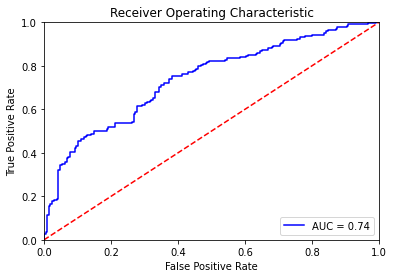

0.7374003189792663

In [ ]:
evaluate_roc(model,df_test)

# Conect to Google Drive to import new downladed tweets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset was created by downloading tweets with the word "Ukraine" using the provided Tweet-download-script.ipynb file

In [ ]:
df_ukraine = pd.read_csv('/content/drive/MyDrive/tweets_ukraine.csv')
df_ukraine.drop(columns=['Unnamed: 0'], axis=1, inplace =True)
df_ukraine.rename(columns={"0":'tweet'},inplace=True)
df_ukraine['class'] = np.zeros(1000)

## Perform predictions over new dataset

In [ ]:
data = Dataset(df_ukraine)
data_dataloader = torch.utils.data.DataLoader(data, batch_size=1)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
predictions = pd.DataFrame(columns=['tweet','pred-0','pred-1'])
i=0
for test_input, test_label in data_dataloader:

      test_label = test_label.to(device)
      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)
      #print(output.argmax(dim=1),test_label)
      predictions = predictions.append({'tweet':df_ukraine.iloc[i,0], 'pred-0':output.cpu().detach().numpy()[0][0],'pred-1':output.cpu().detach().numpy()[0][1]},ignore_index=True)
      i+=1

## Sample of the first 10 results for predictions and tweets

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
predictions.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet,pred-0,pred-1
0,RT @KyivIndependent: Ukraine's General Staff report: \n\n🔵 Russia transfers new troops to Belarus to replenish its assault force\n🟡 4 Russian…,0.501387,0.498613
1,"RT @caitoz: The US alliance is pouring billions worth of weapons into Ukraine, the CIA has been training Ukrainians to kill Russians, the U…",0.504828,0.495172
2,RT @spectatorindex: BREAKING: Ukraine's Defense Ministry says Russia has created a partial land corridor between Crimea and the Donetsk reg…,0.471206,0.528794
3,RT @ALocalAmerican: @TexitDallasCo Remember. Borders and guns are only for Ukraine.,0.492631,0.507369
4,RT @dkaleniuk: Brussels yesterday right near the European Commission. 902 people died officially in Ukraine because of russian aggression a…,0.491117,0.508883
5,RT @RNCResearch: Today Biden again said that sanctions would not “deter” Putin from invading Ukraine. \n \nHis administration said the EXACT…,0.496276,0.503724
6,"RT @Lord_Arse: It has been reported that the Mariupol Computer Museum in Ukraine, a privately owned collection of over 500 items of retro c…",0.467583,0.532417
7,"@online_ukraine Ukraine? Your A$$🤬. Do you Russians think everyone is stupid? All you did was change the ""Russia… https://t.co/TDelBEkvxB",0.471399,0.528601
8,"RT @lapatina_: In Russia, Ukrainians are ""offered"" official employment, and those who agree receive documents banning them from leaving tho…",0.477354,0.522646
9,RT @BeautyTies: Art lovers unite and bid for this masterpiece by @DrPamSpurr \nThis piece is thought provoking and emotional. Funds go towar…,0.525991,0.474009


## Sample results for specific tweets

In [ ]:
print(predictions.iloc[7,0],'Non-Hate Probability',
predictions.iloc[7,1],'Hate Probability',
predictions.iloc[7,2])

@online_ukraine Ukraine?  Your A$$🤬.  Do you Russians think everyone is stupid?  All you did was change the "Russia… https://t.co/TDelBEkvxB Non-Hate Probability 0.4713986 Hate Probability 0.52860147


In [ ]:
print(predictions.iloc[49,0],'Non-Hate Probability',
predictions.iloc[49,1],'Hate Probability',
predictions.iloc[49,2])

@roberts23215778 @SamRamani2 No, we hate what Russia does to its neighbours in Georgia and Ukraine and to its own p… https://t.co/b226pjrh4p Non-Hate Probability 0.4831444 Hate Probability 0.5168556
